# Predictive Capabilities of Various Machine Learning Algorithms for Solar Forecasting

### Background

Solar PV has been becoming a more significant part of the electric grid in the United States over the past 20 years and its role is only expected to increase. The Solar Energy Industries Association (SEIA) estimates there were close to 90,000 MWdc of installations in the US in 2020. 

![SEIA Cumulative US PV Installations](Images/Cumulative_PV_Installtions_US.png)
Source: [SEIA](https://www.seia.org/solar-industry-research-data)

With more and more solar PV contributing to electricity production in the United States, better forecasting models will be needed to maintain the stability of the electric grid and optimize the utilization of grid resources such as energy storage devices as well as other types of generating facilities. 

For this project I have downloaded 30 minute interval weather data from various locations around Pittsburgh, Pennsylvania from the National Renewable Energy Lab's [National Soalar Radiation Database (NSRDB) viewer](https://maps.nrel.gov/nsrdb-viewer/). I will use this data to forecast the Global Horizontal Irradiance(GHI) in Pittsburgh 4 hours ahead of the most recent measurements. GHI is the combination of Direct Normal Irradiance (DNI) and Diffuse Horizontal Irradiance (DHI) and is the most important value to know when calculating the production of a PV array.

![GHI vs DNI and DHI](Images/GHI_DNI_DHI.png)
Source: [Homer Energy](https://www.homerenergy.com/products/pro/docs/latest/global_horizontal_irradiance_ghi.html)

The locations from which data was gathered can be seen below.

![City Data Sources](Images/City_Data_Sources.png)

In this notebook, a few machine learning algorithms will be explored to determine which may be the most useful for the task of forecasting GHI.

## Data

As stated before, data was acquired from NREL's NSRDB for various locations around Pittsburgh, PA. Data was collected and reported in 30 minute increments. Data was collected for the years 1998-2019. A sample of the data can be seen below.

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import pickle

# Load Pittsburgh-only data
with open('PIT_dict.pkl', 'rb') as f:
    PIT_dict = pickle.load(f)

PIT_df = PIT_dict['complete_data']
# Use only the weather-related columns, not time
cols = list(PIT_df.columns)


PIT_weather = PIT_df[cols].copy()

PIT_weather.head()

,Time_X,Time_Y,Day_X,Day_Y,PIT_DHI,PIT_DNI,PIT_GHI,PIT_Clearsky DHI,PIT_Clearsky DNI,PIT_Clearsky GHI,PIT_Dew Point,PIT_Surface Albedo,PIT_Wind_X,PIT_Wind_Y,PIT_Relative Humidity,PIT_Temperature,PIT_Pressure,PIT_Global Horizontal UV Irradiance (280-400nm),PIT_Global Horizontal UV Irradiance (295-385nm)
0,0.000000,1.000000,0.017213,0.999852,0,0,0,0,0,0,-14.0,0.866,-0.524772,-0.290886,81.30,-11.0,990,0.0,0.0
1,0.130526,0.991445,0.017213,0.999852,0,0,0,0,0,0,-14.0,0.866,-0.524772,-0.290886,81.32,-11.0,990,0.0,0.0
2,0.258819,0.965926,0.017213,0.999852,0,0,0,0,0,0,-14.0,0.866,-0.508829,-0.317952,79.56,-11.0,990,0.0,0.0
3,0.382683,0.923880,0.017213,0.999852,0,0,0,0,0,0,-14.0,0.866,-0.508829,-0.317952,79.57,-11.0,990,0.0,0.0
4,0.500000,0.866025,0.017213,0.999852,0,0,0,0,0,0,-14.0,0.866,-0.430146,-0.418299,78.91,-12.0,990,0.0,0.0


Above is a sample of the weather data collected only from Pittsburgh. The columns **Time_X** and **Time_Y** represent the x and y coordinates of the time if time were mapped to a unit circle with midnight at (0, 1) and progressing in a clockwise fashion for the duration of a single day. In this scenario noon would be represented by the coordinates (0, -1). Similarly, **Day_X** and **Day_Y** represent the x and y coordinated of the day of the year mapped to a unit circle with January 1 at approximately (0, 1) and progressing in a clockwise fashion for the duration of the year. 

The full data has only one column for each of  **Time_X**, **Time_Y**, **Day_X** and **Day_Y**, but for each of the other columns, there are 15 columns, one for each city.

In [2]:
# Load full-city data
with open('full_cities_dict.pkl', 'rb') as f:
    full_cities_dict = pickle.load(f)

full_cities_df = full_cities_dict['complete_data']
# Use only the weather-related columns, not time
cols = list(full_cities_df.columns)

full_cities_weather = full_cities_df[cols].copy()

full_cities_weather.head()


,Time_X,Time_Y,Day_X,Day_Y,PIT_DHI,PIT_DNI,PIT_GHI,PIT_Clearsky DHI,PIT_Clearsky DNI,PIT_Clearsky GHI,...,YGT_Clearsky GHI,YGT_Dew Point,YGT_Surface Albedo,YGT_Wind_X,YGT_Wind_Y,YGT_Relative Humidity,YGT_Temperature,YGT_Pressure,YGT_Global Horizontal UV Irradiance (280-400nm),YGT_Global Horizontal UV Irradiance (295-385nm)
0,0.000000,1.000000,0.017213,0.999852,0,0,0,0,0,0,...,0,-13.0,0.866,-0.424946,-0.263478,81.02,-10.0,990,0.0,0.0
1,0.130526,0.991445,0.017213,0.999852,0,0,0,0,0,0,...,0,-13.0,0.866,-0.424946,-0.263478,81.03,-10.0,990,0.0,0.0
2,0.258819,0.965926,0.017213,0.999852,0,0,0,0,0,0,...,0,-13.0,0.866,-0.381334,-0.323395,78.83,-10.0,990,0.0,0.0
3,0.382683,0.923880,0.017213,0.999852,0,0,0,0,0,0,...,0,-13.0,0.866,-0.381334,-0.323395,78.84,-10.0,990,0.0,0.0
4,0.500000,0.866025,0.017213,0.999852,0,0,0,0,0,0,...,0,-14.0,0.866,-0.288929,-0.408069,76.75,-11.0,990,0.0,0.0


## Data Preparation

Various machine learning techniques will be demonstrated all with the aim of predicting the GHI in Pittsburgh 4 hours ahead of the latest weather measurements. However, differeing amounts of look-back data will be incorporated. For example, one trial will only use the current measuremnts, will another will use the current and previous measurement (taken 30 minutes prior), yet another will use the current and 3 previous measurements. 

After creating these new datasets, they must be split into training, validation, and testing sets and then normalized.

In [3]:
# creates time-based columns to relect the desired features looking back in time and outputs the feature df and target df
def feature_target_split(df, look_back_steps, forecast_ahead_steps, target_col_name):
    
    feature_names = df.columns
    t_steps_back = range(look_back_steps + 1)
    time_features = pd.DataFrame()
    target_feature = pd.DataFrame()
    for feature in feature_names:
        if (feature == 'Day_X') or (feature == 'Day_Y') or (feature == 'Time_X') or (feature == 'Time_Y'):
            time_features[feature] = df[feature].iloc[look_back_steps : 0 - forecast_ahead_steps].reset_index(drop=True)
        else:
            for t_back in t_steps_back:
                t_feature_col_name = feature + "-" + str(t_back)
                time_features[t_feature_col_name] = df[feature].iloc[(look_back_steps - t_back) : 0 - forecast_ahead_steps - t_back].reset_index(drop=True)
    new_target_col_name = target_col_name + "+" + str(forecast_ahead_steps)
    target_feature[new_target_col_name] = df[target_col_name].iloc[look_back_steps + forecast_ahead_steps : ].reset_index(drop=True)

    return time_features, target_feature

In [4]:
# creates differerent datasets based on how many look-back measurements are used
current_only_features, current_only_target = feature_target_split(full_cities_weather, 0, 8, 'PIT_GHI')
current_and_previous_features, current_and_previous_target = feature_target_split(full_cities_weather, 1, 8, 'PIT_GHI')
current_and_previous_3_features, current_and_previous_3_target = feature_target_split(full_cities_weather, 3, 8, 'PIT_GHI')


In [5]:
from sklearn.model_selection import train_test_split

# split all datasets into train_val and test sets
X_current_only_train_val, X_current_only_test, y_current_only_train_val, y_current_only_test = \
train_test_split(current_only_features, current_only_target, test_size=0.2, shuffle=False)

X_current_and_previous_train_val, X_current_and_previous_test, y_current_and_previous_train_val, y_current_and_previous_test = \
train_test_split(current_and_previous_features, current_and_previous_target, test_size=0.2, shuffle=False)

X_current_and_previous_3_train_val, X_current_and_previous_3_test, y_current_and_previous_3_train_val, y_current_and_previous_3_test = \
train_test_split(current_and_previous_3_features, current_and_previous_3_target, test_size=0.2, shuffle=False)

# split all train_val sets into train and val sets
X_current_only_train, X_current_only_val, y_current_only_train, y_current_only_val = \
train_test_split(X_current_only_train_val, y_current_only_train_val, test_size=0.2, shuffle=False)

X_current_and_previous_train, X_current_and_previous_val, y_current_and_previous_train, y_current_and_previous_val = \
train_test_split(X_current_and_previous_train_val, y_current_and_previous_train_val, test_size=0.2, shuffle=False)

X_current_and_previous_3_train, X_current_and_previous_3_val, y_current_and_previous_3_train, y_current_and_previous_3_val = \
train_test_split(X_current_and_previous_3_train_val, y_current_and_previous_3_train_val, test_size=0.2, shuffle=False)
 


In [6]:
from sklearn.preprocessing import MinMaxScaler

# scaler for current_only_train data
X_current_only_train_scaler = MinMaxScaler()
y_current_only_train_scaler = MinMaxScaler()

# fit and transform current_only_train sets
X_current_only_train_norm = X_current_only_train_scaler.fit_transform(X_current_only_train)
y_current_only_train_norm = y_current_only_train_scaler.fit_transform(y_current_only_train)

# transform current_only_val set
X_current_only_val_norm = X_current_only_train_scaler.transform(X_current_only_val)

# scaler for current_only_train_val data
X_current_only_train_val_scaler = MinMaxScaler()
y_current_only_train_val_scaler = MinMaxScaler()

# fit and transform current_only_train_val sets
X_current_only_train_val_norm = X_current_only_train_val_scaler.fit_transform(X_current_only_train_val)
y_current_only_train_val_norm = y_current_only_train_val_scaler.fit_transform(y_current_only_train_val)

# transform current_only_test set
X_current_only_test_norm = X_current_only_train_val_scaler.transform(X_current_only_test)




# sclaer for current_and_previous_train data
X_current_and_previous_train_scaler = MinMaxScaler()
y_current_and_previous_train_scaler = MinMaxScaler()

# fit and transform current_and_previous_train sets
X_current_and_previous_train_norm = X_current_and_previous_train_scaler.fit_transform(X_current_and_previous_train)
y_current_and_previous_train_norm = y_current_and_previous_train_scaler.fit_transform(y_current_and_previous_train)

# transform current_and_previous_val set
X_current_and_previous_val_norm = X_current_and_previous_train_scaler.transform(X_current_and_previous_val)

# scaler for current_and_previous_train_val data
X_current_and_previous_train_val_scaler = MinMaxScaler()
y_current_and_previous_train_val_scaler = MinMaxScaler()

# fit and transform current_and_previous_train_val sets
X_current_and_previous_train_val_norm = X_current_and_previous_train_val_scaler.fit_transform(X_current_and_previous_train_val)
y_current_and_previous_train_val_norm = y_current_and_previous_train_val_scaler.fit_transform(y_current_and_previous_train_val)

# transform current_and_previous_test set
X_current_and_previous_test_norm = X_current_and_previous_train_val_scaler.transform(X_current_and_previous_test)




# sclaer for current_and_previous_3_train data
X_current_and_previous_3_train_scaler = MinMaxScaler()
y_current_and_previous_3_train_scaler = MinMaxScaler()

# fit and transform current_and_previous_3_train sets
X_current_and_previous_3_train_norm = X_current_and_previous_3_train_scaler.fit_transform(X_current_and_previous_3_train)
y_current_and_previous_3_train_norm = y_current_and_previous_3_train_scaler.fit_transform(y_current_and_previous_3_train)

# transform current_and_previous_3_val set
X_current_and_previous_3_val_norm = X_current_and_previous_3_train_scaler.transform(X_current_and_previous_3_val)

# scaler for current_and_previous_3_train_val data
X_current_and_previous_3_train_val_scaler = MinMaxScaler()
y_current_and_previous_3_train_val_scaler = MinMaxScaler()

# fit and transform current_and_previous_3_train_val sets
X_current_and_previous_3_train_val_norm = X_current_and_previous_3_train_val_scaler.fit_transform(X_current_and_previous_3_train_val)
y_current_and_previous_3_train_val_norm = y_current_and_previous_3_train_val_scaler.fit_transform(y_current_and_previous_3_train_val)

# transform current_and_previous_3_test set
X_current_and_previous_3_test_norm = X_current_and_previous_3_train_val_scaler.transform(X_current_and_previous_3_test)


## Linear Model

The first model attempted will be a simple linear regression model where ridge methods are employed.

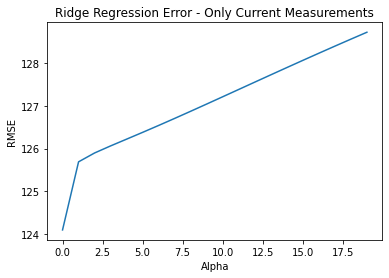

In [7]:
from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

scores = []
alpha = range(0, 20)

for a in alpha:
    if a == 0:
        model = LinearRegression()
    else:
        model = Ridge(alpha=a)
    model.fit(X_current_only_train_norm, y_current_only_train_norm)
    prediction = model.predict(X_current_only_val_norm)
    
    prediction = y_current_only_train_scaler.inverse_transform(prediction)
    actual = y_current_only_val
    
    scores.append(mean_squared_error(actual, prediction, squared=False))

plt.plot(alpha, scores)
plt.title('Ridge Regression Error - Only Current Measurements')
plt.xlabel('Alpha')
plt.ylabel('RMSE')
plt.show()


It appears that the linear regression model with no regularization performs the best. Therefore, the combined training and validation sets will used to fit the model. Then the model will be finally evaluated on the testing set.

In [8]:
# Create and fit linear regression model. Use combined training and validation dataset.
model = LinearRegression()
model.fit(X_current_only_train_val_norm, y_current_only_train_val_norm)

# evaluate model on test set
prediction = model.predict(X_current_only_test_norm)
prediction = y_current_only_train_val_scaler.inverse_transform(prediction)
actual = y_current_only_test.to_numpy()

best_current_only_linreg_rmse = mean_squared_error(actual, prediction, squared=False)
best_current_only_linreg_rmse


121.84494832232866

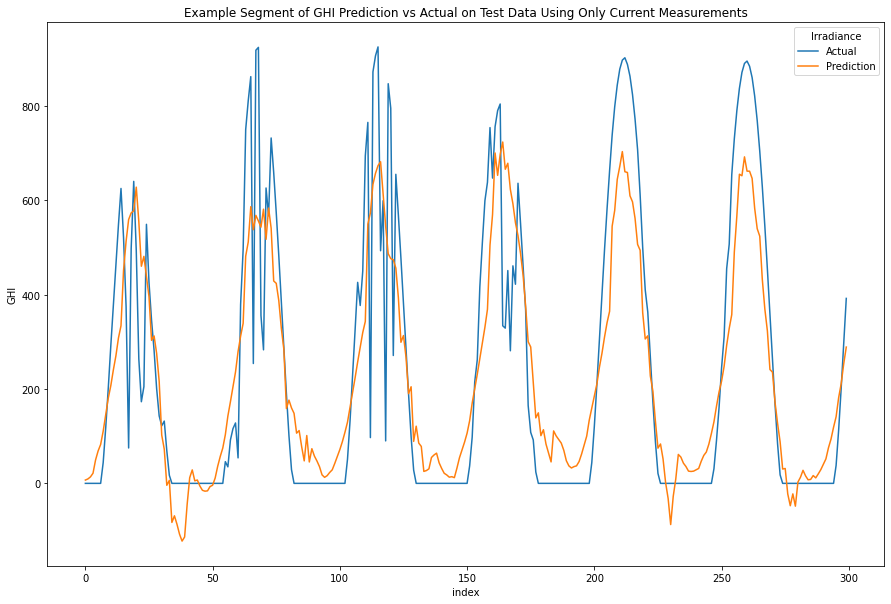

In [9]:
plot_df = pd.DataFrame({'Actual' : actual[100:400,0], 'Prediction' : prediction[100:400,0]})
plot_df = plot_df.reset_index().melt('index', var_name='Irradiance', value_name='GHI')

fig = plt.figure(figsize=(15,10))
sns.lineplot(data=plot_df, x='index', y='GHI', hue='Irradiance')
plt.title('Example Segment of GHI Prediction vs Actual on Test Data Using Only Current Measurements')
plt.show()

The same previous steps will be repeated but incorporating previous measurements rather than just current measurements.

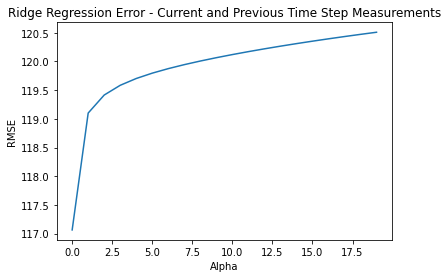

In [10]:
scores = []
alpha = range(0, 20)

for a in alpha:
    if a == 0:
        model = LinearRegression()
    else:
        model = Ridge(alpha=a)
    model.fit(X_current_and_previous_train_norm, y_current_and_previous_train_norm)
    prediction = model.predict(X_current_and_previous_val_norm)
    
    prediction = y_current_and_previous_train_scaler.inverse_transform(prediction)
    actual = y_current_and_previous_val
    
    scores.append(mean_squared_error(actual, prediction, squared=False))

plt.plot(alpha, scores)
plt.title('Ridge Regression Error - Current and Previous Time Step Measurements')
plt.xlabel('Alpha')
plt.ylabel('RMSE')
plt.show()


In [11]:
# Create and fit linear regression model. Use combined training and validation dataset.
model = LinearRegression()
model.fit(X_current_and_previous_train_val_norm, y_current_and_previous_train_val_norm)

# evaluate model on test set
prediction = model.predict(X_current_and_previous_test_norm)
prediction = y_current_and_previous_train_val_scaler.inverse_transform(prediction)
actual = y_current_and_previous_test.to_numpy()

best_current_and_previous_linreg_rmse = mean_squared_error(actual, prediction, squared=False)
best_current_and_previous_linreg_rmse

114.04326599406981

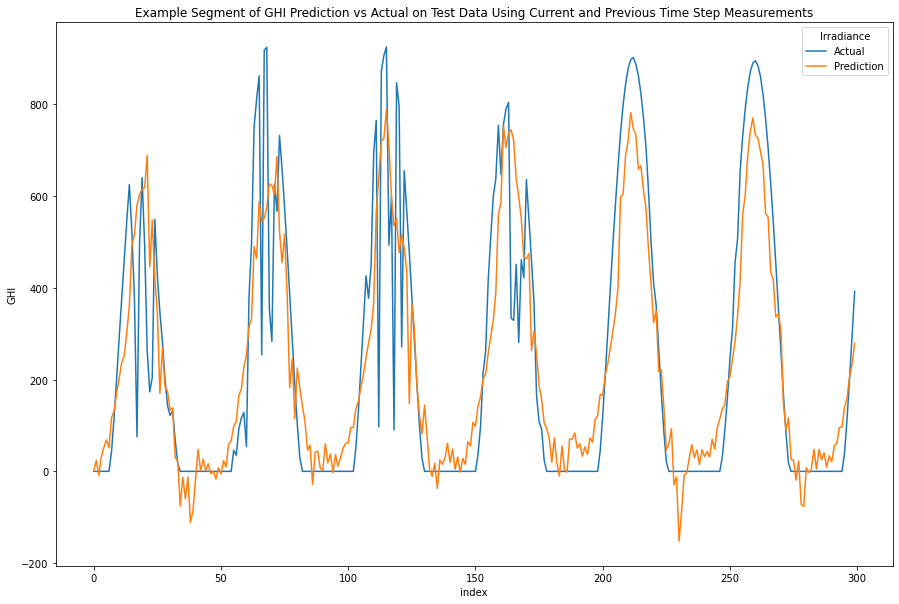

In [12]:
plot_df = pd.DataFrame({'Actual' : actual[100:400,0], 'Prediction' : prediction[100:400,0]})
plot_df = plot_df.reset_index().melt('index', var_name='Irradiance', value_name='GHI')

fig = plt.figure(figsize=(15,10))
sns.lineplot(data=plot_df, x='index', y='GHI', hue='Irradiance')
plt.title('Example Segment of GHI Prediction vs Actual on Test Data Using Current and Previous Time Step Measurements')
plt.show()

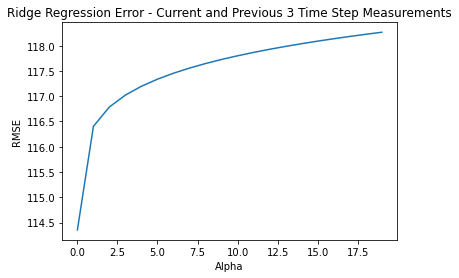

In [13]:
scores = []
alpha = range(0, 20)

for a in alpha:
    if a == 0:
        model = LinearRegression()
    else:
        model = Ridge(alpha=a)
    model.fit(X_current_and_previous_3_train_norm, y_current_and_previous_3_train_norm)
    prediction = model.predict(X_current_and_previous_3_val_norm)
    
    prediction = y_current_and_previous_3_train_scaler.inverse_transform(prediction)
    actual = y_current_and_previous_3_val
    
    scores.append(mean_squared_error(actual, prediction, squared=False))

plt.plot(alpha, scores)
plt.title('Ridge Regression Error - Current and Previous 3 Time Step Measurements')
plt.xlabel('Alpha')
plt.ylabel('RMSE')
plt.show()


In [14]:
# Create and fit linear regression model. Use combined training and validation dataset.
model = LinearRegression()
model.fit(X_current_and_previous_3_train_val_norm, y_current_and_previous_3_train_val_norm)

# evaluate model on test set
prediction = model.predict(X_current_and_previous_3_test_norm)
prediction = y_current_and_previous_3_train_val_scaler.inverse_transform(prediction)
actual = y_current_and_previous_3_test.to_numpy()

best_current_and_previous_3_linreg_rmse = mean_squared_error(actual, prediction, squared=False)
best_current_and_previous_3_linreg_rmse

112.46274411076315

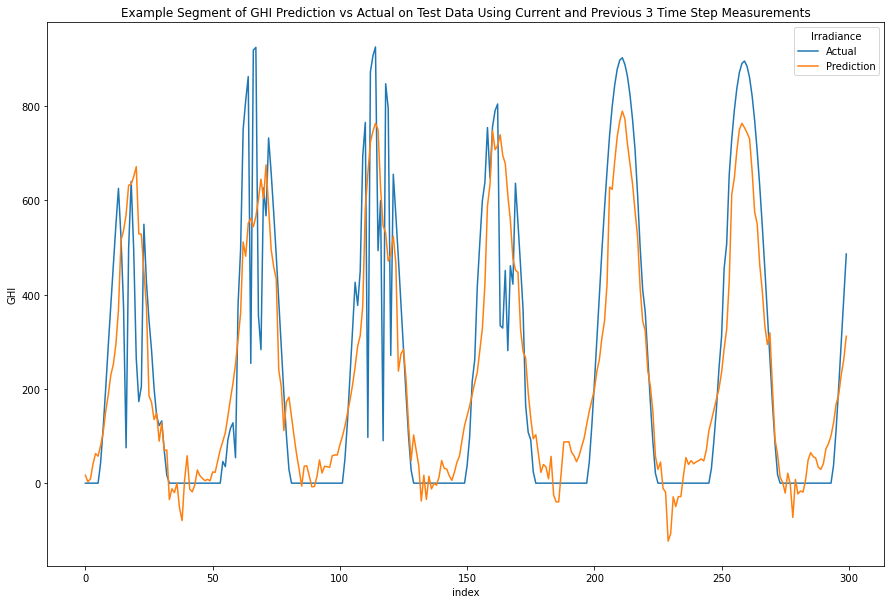

In [15]:
plot_df = pd.DataFrame({'Actual' : actual[100:400,0], 'Prediction' : prediction[100:400,0]})
plot_df = plot_df.reset_index().melt('index', var_name='Irradiance', value_name='GHI')

fig = plt.figure(figsize=(15,10))
sns.lineplot(data=plot_df, x='index', y='GHI', hue='Irradiance')
plt.title('Example Segment of GHI Prediction vs Actual on Test Data Using Current and Previous 3 Time Step Measurements')
plt.show()

So we see that adding previous time steps of data does appear to improve the model's predictive capabilities.

Next, a decision tree will be used to develop a model.

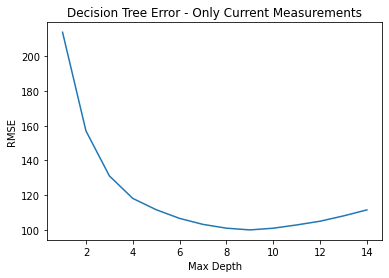

In [16]:
from sklearn.tree import DecisionTreeRegressor

scores = []
max_depths = range(1, 15)

for d in max_depths:

    model = DecisionTreeRegressor(max_depth=d, random_state=15217)
    model.fit(X_current_only_train_norm, y_current_only_train_norm)
    prediction = model.predict(X_current_only_val_norm)
    
    prediction = y_current_only_train_scaler.inverse_transform(prediction.reshape(-1,1))
    actual = y_current_only_val
    
    scores.append(mean_squared_error(actual, prediction, squared=False))

plt.plot(max_depths, scores)
plt.title('Decision Tree Error - Only Current Measurements')
plt.xlabel('Max Depth')
plt.ylabel('RMSE')
plt.show()


In [17]:
# Create and fit decision tree model. Use combined training and validation dataset.
model = DecisionTreeRegressor(max_depth=9 , random_state=15217)
model.fit(X_current_only_train_val_norm, y_current_only_train_val_norm)

# evaluate model on test set
prediction = model.predict(X_current_only_test_norm)
prediction = y_current_only_train_val_scaler.inverse_transform(prediction.reshape(-1,1))
actual = y_current_only_test.to_numpy()

best_current_only_tree_rmse = mean_squared_error(actual, prediction, squared=False)
best_current_only_tree_rmse


98.41579832507797

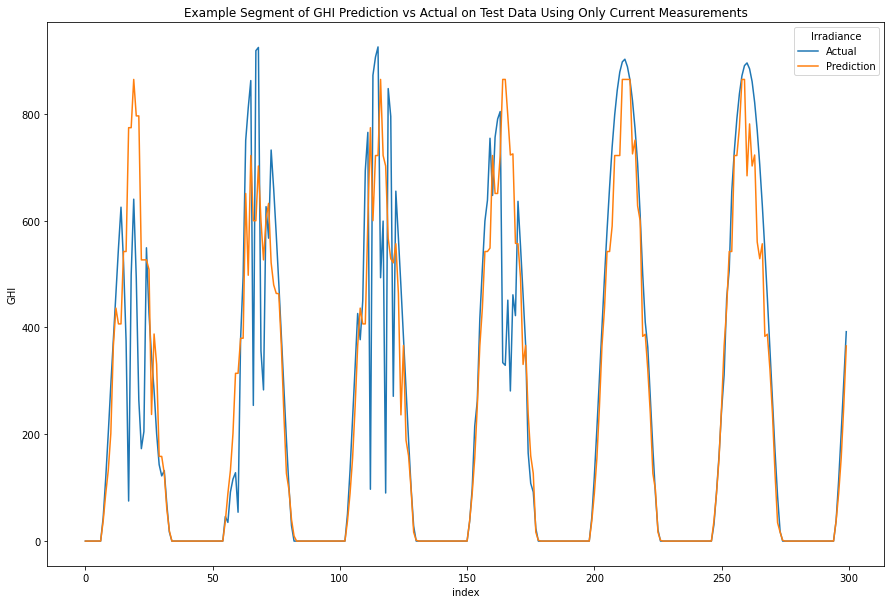

In [18]:
plot_df = pd.DataFrame({'Actual' : actual[100:400,0], 'Prediction' : prediction[100:400,0]})
plot_df = plot_df.reset_index().melt('index', var_name='Irradiance', value_name='GHI')

fig = plt.figure(figsize=(15,10))
sns.lineplot(data=plot_df, x='index', y='GHI', hue='Irradiance')
plt.title('Example Segment of GHI Prediction vs Actual on Test Data Using Only Current Measurements')
plt.show()

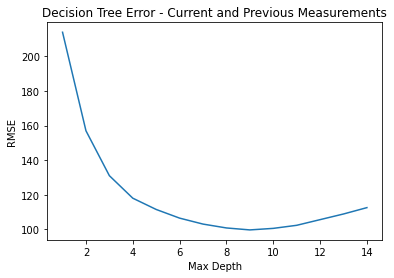

In [19]:
from sklearn.tree import DecisionTreeRegressor

scores = []
max_depths = range(1, 15)

for d in max_depths:

    model = DecisionTreeRegressor(max_depth=d, random_state=15217)
    model.fit(X_current_and_previous_train_norm, y_current_and_previous_train_norm)
    prediction = model.predict(X_current_and_previous_val_norm)
    
    prediction = y_current_and_previous_train_scaler.inverse_transform(prediction.reshape(-1,1))
    actual = y_current_and_previous_val
    
    scores.append(mean_squared_error(actual, prediction, squared=False))

plt.plot(max_depths, scores)
plt.title('Decision Tree Error - Current and Previous Measurements')
plt.xlabel('Max Depth')
plt.ylabel('RMSE')
plt.show()

In [20]:
# Create and fit decision tree model. Use combined training and validation dataset.
model = DecisionTreeRegressor(max_depth=9 , random_state=15217)
model.fit(X_current_and_previous_train_val_norm, y_current_and_previous_train_val_norm)

# evaluate model on test set
prediction = model.predict(X_current_and_previous_test_norm)
prediction = y_current_and_previous_train_val_scaler.inverse_transform(prediction.reshape(-1,1))
actual = y_current_and_previous_test.to_numpy()

best_current_and_previous_tree_rmse = mean_squared_error(actual, prediction, squared=False)
best_current_and_previous_tree_rmse


98.56636399871765

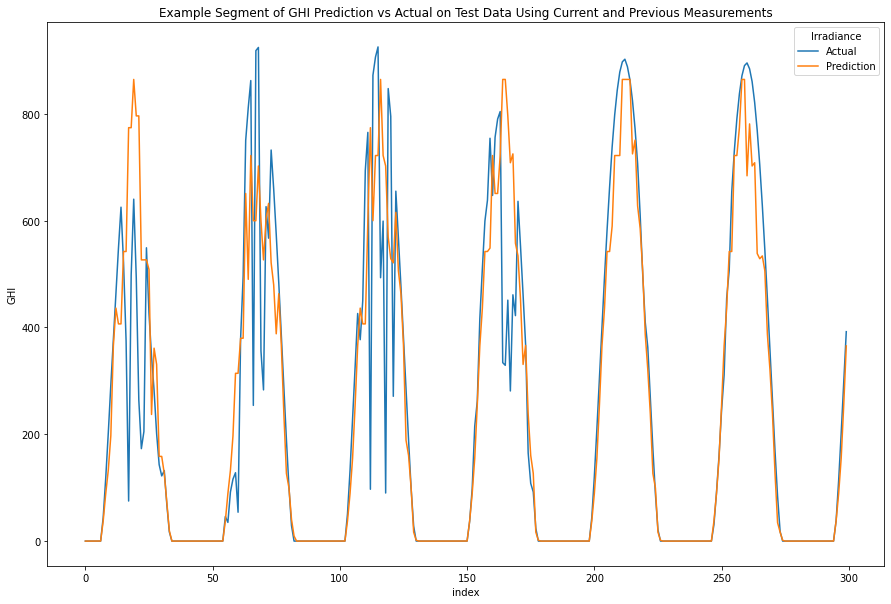

In [21]:
plot_df = pd.DataFrame({'Actual' : actual[100:400,0], 'Prediction' : prediction[100:400,0]})
plot_df = plot_df.reset_index().melt('index', var_name='Irradiance', value_name='GHI')

fig = plt.figure(figsize=(15,10))
sns.lineplot(data=plot_df, x='index', y='GHI', hue='Irradiance')
plt.title('Example Segment of GHI Prediction vs Actual on Test Data Using Current and Previous Measurements')
plt.show()

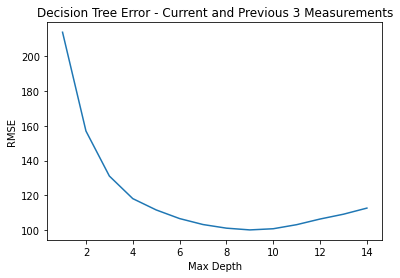

In [22]:
from sklearn.tree import DecisionTreeRegressor

scores = []
max_depths = range(1, 15)

for d in max_depths:

    model = DecisionTreeRegressor(max_depth=d, random_state=15217)
    model.fit(X_current_and_previous_3_train_norm, y_current_and_previous_3_train_norm)
    prediction = model.predict(X_current_and_previous_3_val_norm)
    
    prediction = y_current_and_previous_3_train_scaler.inverse_transform(prediction.reshape(-1,1))
    actual = y_current_and_previous_3_val
    
    scores.append(mean_squared_error(actual, prediction, squared=False))

plt.plot(max_depths, scores)
plt.title('Decision Tree Error - Current and Previous 3 Measurements')
plt.xlabel('Max Depth')
plt.ylabel('RMSE')
plt.show()

In [23]:
# Create and fit decision tree model. Use combined training and validation dataset.
model = DecisionTreeRegressor(max_depth=9 , random_state=15217)
model.fit(X_current_and_previous_3_train_val_norm, y_current_and_previous_3_train_val_norm)

# evaluate model on test set
prediction = model.predict(X_current_and_previous_3_test_norm)
prediction = y_current_and_previous_3_train_val_scaler.inverse_transform(prediction.reshape(-1,1))
actual = y_current_and_previous_3_test.to_numpy()

best_current_and_previous_3_tree_rmse = mean_squared_error(actual, prediction, squared=False)
best_current_and_previous_3_tree_rmse


98.49233861725402

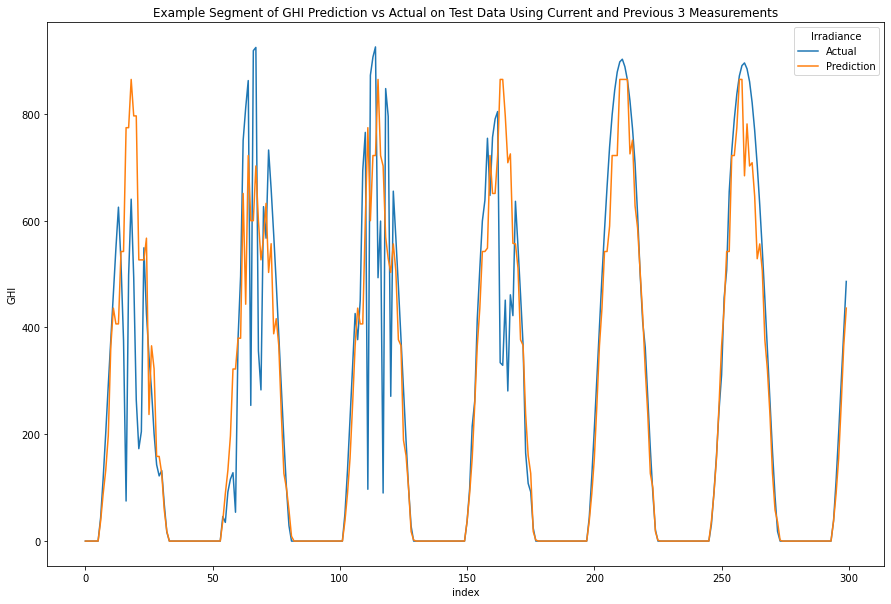

In [24]:
plot_df = pd.DataFrame({'Actual' : actual[100:400,0], 'Prediction' : prediction[100:400,0]})
plot_df = plot_df.reset_index().melt('index', var_name='Irradiance', value_name='GHI')

fig = plt.figure(figsize=(15,10))
sns.lineplot(data=plot_df, x='index', y='GHI', hue='Irradiance')
plt.title('Example Segment of GHI Prediction vs Actual on Test Data Using Current and Previous 3 Measurements')
plt.show()

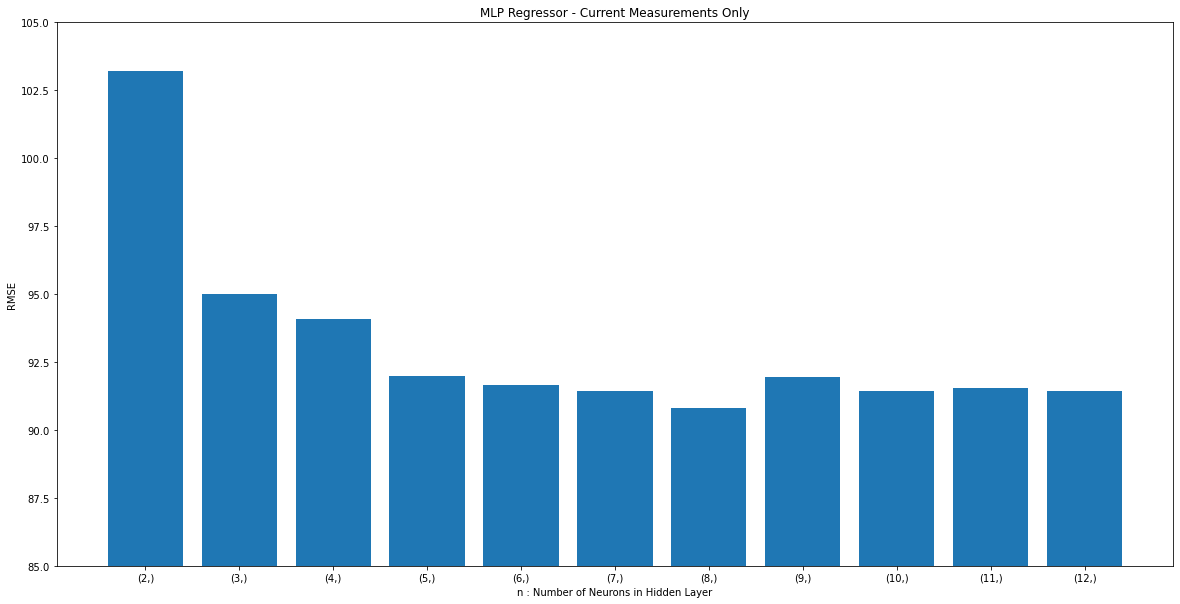

In [10]:
from sklearn.neural_network import MLPRegressor

scores = []
num_neurons1 = range(2,13)
num_neurons2 = range(0,1)
labels = []

for n1 in num_neurons1:
    for n2 in num_neurons2:
        if n2 == 0:
            model = MLPRegressor(random_state = 15217, hidden_layer_sizes = (2**n1,), early_stopping=True, validation_fraction = 0.2, n_iter_no_change = 5)
        else:
            model = MLPRegressor(random_state = 15217, hidden_layer_sizes = (2**n1,2**n2), early_stopping=True)
        model.fit(X_current_only_train_norm, y_current_only_train_norm.ravel())
        prediction = model.predict(X_current_only_val_norm)

        prediction = y_current_only_train_scaler.inverse_transform(prediction.reshape(-1,1))
        actual = y_current_only_val

        scores.append(mean_squared_error(actual, prediction, squared=False))
        if n2==0:
            labels.append("{n1}".format(n1=n1))
        else:
            labels.append("({n1},{n2})".format(n1=n1,n2=n2))

fig = plt.figure(figsize=(20,10))

plt.title('MLP Regressor - Current Measurements Only')
plt.xlabel('n : Number of Neurons in Hidden Layer is $\mathregular{2^{n}}$')
x = range(len(labels))
plt.xticks(x, labels)
plt.ylabel('RMSE')
plt.bar(labels, scores)
plt.ylim(85, 105) 
plt.show()



In [13]:
val, idx = min((val, idx) for (idx, val) in enumerate(scores))
print(val, idx)

90.80505358787002 6


In [14]:
labels[idx]

'(8,)'

In [15]:
# Create and fit a MLP Regressor. Use combined training and validation dataset.
model = MLPRegressor(random_state = 15217, hidden_layer_sizes = (2**8,), early_stopping=True, validation_fraction = 0.2, n_iter_no_change = 5)
model.fit(X_current_only_train_val_norm, y_current_only_train_val_norm.ravel())

# evaluate model on test set
prediction = model.predict(X_current_only_test_norm)
prediction = y_current_only_train_val_scaler.inverse_transform(prediction.reshape(-1,1))
actual = y_current_only_test.to_numpy()

best_current_only_mlpr_rmse = mean_squared_error(actual, prediction, squared=False)
best_current_only_mlpr_rmse


87.63232343711547

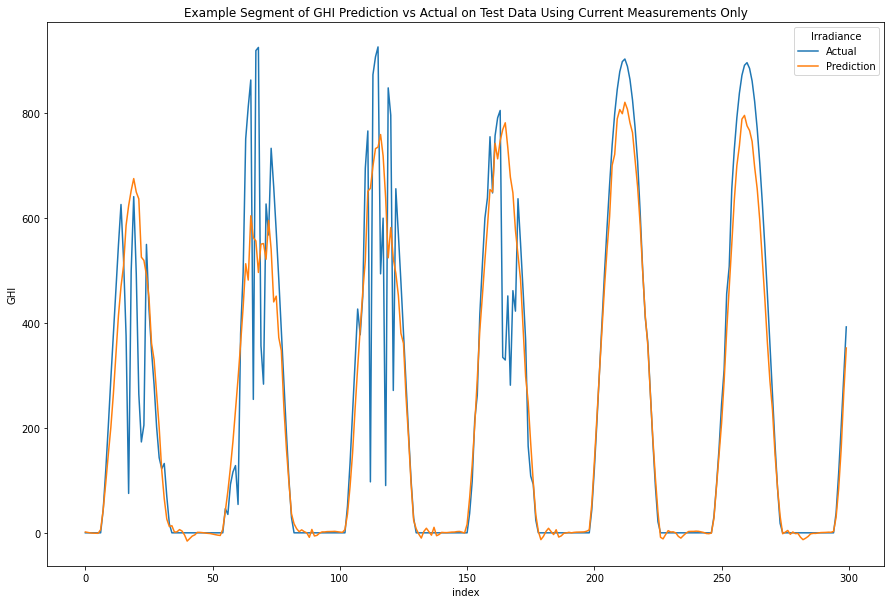

In [16]:
plot_df = pd.DataFrame({'Actual' : actual[100:400,0], 'Prediction' : prediction[100:400,0]})
plot_df = plot_df.reset_index().melt('index', var_name='Irradiance', value_name='GHI')

fig = plt.figure(figsize=(15,10))
sns.lineplot(data=plot_df, x='index', y='GHI', hue='Irradiance')
plt.title('Example Segment of GHI Prediction vs Actual on Test Data Using Current Measurements Only')
plt.show()

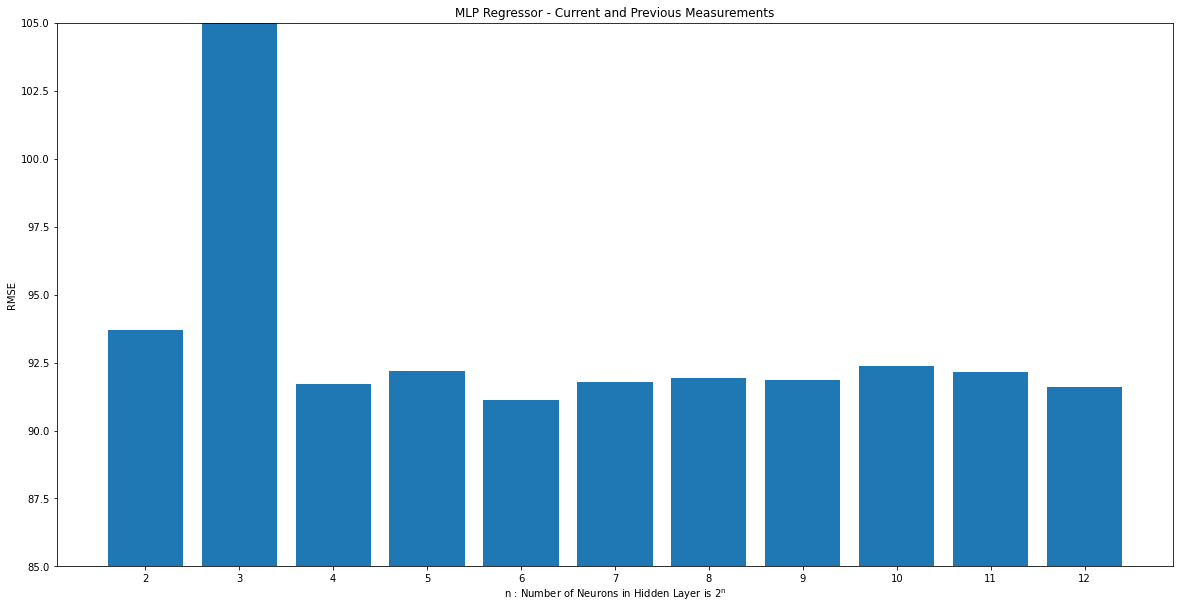

In [17]:
scores = []
num_neurons1 = range(2,13)
num_neurons2 = range(0,1)
labels = []

for n1 in num_neurons1:
    for n2 in num_neurons2:
        if n2 == 0:
            model = MLPRegressor(random_state = 15217, hidden_layer_sizes = (2**n1,), early_stopping=True, validation_fraction = 0.2, n_iter_no_change = 5)
        else:
            model = MLPRegressor(random_state = 15217, hidden_layer_sizes = (2**n1,2**n2))
        model.fit(X_current_and_previous_train_norm, y_current_and_previous_train_norm.ravel())
        prediction = model.predict(X_current_and_previous_val_norm)

        prediction = y_current_and_previous_train_scaler.inverse_transform(prediction.reshape(-1,1))
        actual = y_current_and_previous_val

        scores.append(mean_squared_error(actual, prediction, squared=False))
        if n2==0:
            labels.append("{n1}".format(n1=n1))
        else:
            labels.append("({n1},{n2})".format(n1=n1,n2=n2))

fig = plt.figure(figsize=(20,10))

plt.title('MLP Regressor - Current and Previous Measurements')
plt.xlabel('n : Number of Neurons in Hidden Layer is $\mathregular{2^{n}}$')
x = range(len(labels))
plt.xticks(x, labels)
plt.ylabel('RMSE')
plt.bar(labels, scores)
plt.ylim(85, 105) 
plt.show()


In [18]:
val, idx = min((val, idx) for (idx, val) in enumerate(scores))
print(val, idx)

91.13793904014749 4


In [19]:
labels[idx]

'6'

In [20]:
# Create and fit a MLP Regressor. Use combined training and validation dataset.
model = MLPRegressor(random_state = 15217, hidden_layer_sizes = (2**6,), early_stopping=True, validation_fraction = 0.2, n_iter_no_change = 5)
model.fit(X_current_and_previous_train_val_norm, y_current_and_previous_train_val_norm.ravel())

# evaluate model on test set
prediction = model.predict(X_current_and_previous_test_norm)
prediction = y_current_and_previous_train_val_scaler.inverse_transform(prediction.reshape(-1,1))
actual = y_current_and_previous_test.to_numpy()

best_current_and_previous_mlpr_rmse = mean_squared_error(actual, prediction, squared=False)
best_current_and_previous_mlpr_rmse


88.69726023776016

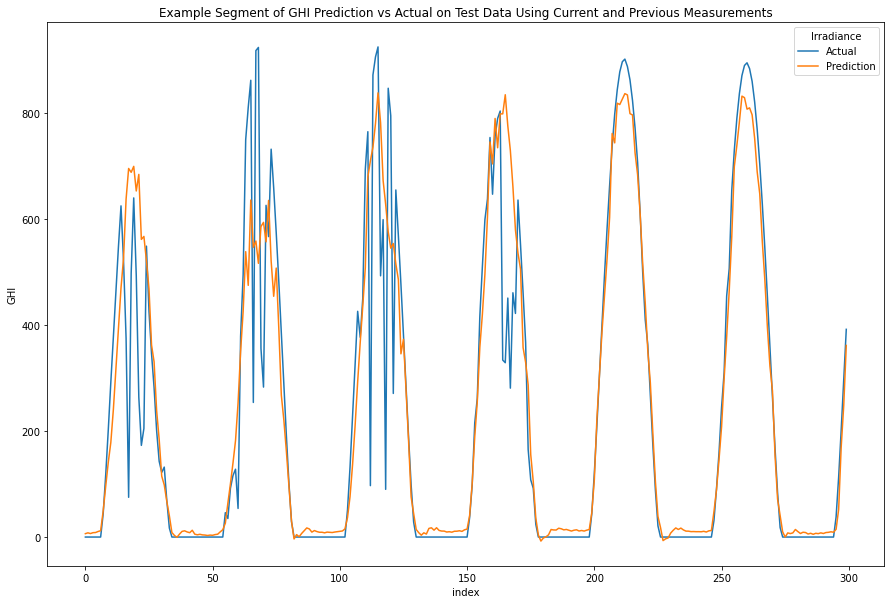

In [21]:
plot_df = pd.DataFrame({'Actual' : actual[100:400,0], 'Prediction' : prediction[100:400,0]})
plot_df = plot_df.reset_index().melt('index', var_name='Irradiance', value_name='GHI')

fig = plt.figure(figsize=(15,10))
sns.lineplot(data=plot_df, x='index', y='GHI', hue='Irradiance')
plt.title('Example Segment of GHI Prediction vs Actual on Test Data Using Current and Previous Measurements')
plt.show()

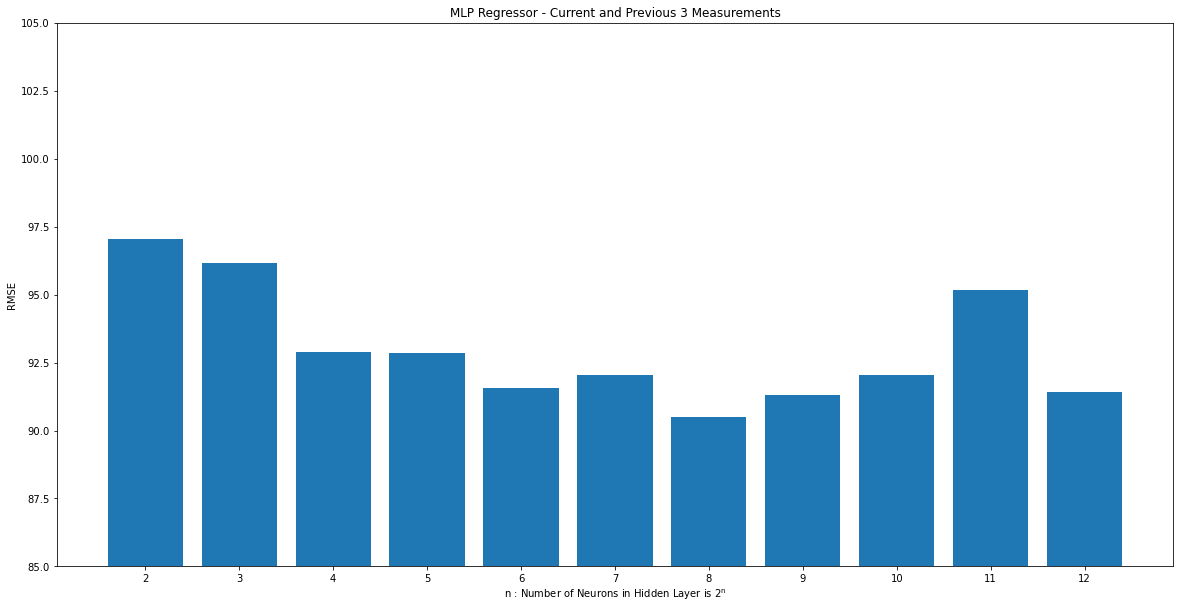

In [22]:
scores = []
num_neurons1 = range(2,13)
num_neurons2 = range(0,1)
labels = []

for n1 in num_neurons1:
    for n2 in num_neurons2:
        if n2 == 0:
            model = MLPRegressor(random_state = 15217, hidden_layer_sizes = (2**n1,), early_stopping=True, validation_fraction = 0.2, n_iter_no_change = 5)
        else:
            model = MLPRegressor(random_state = 15217, hidden_layer_sizes = (2**n1,2**n2))
        model.fit(X_current_and_previous_3_train_norm, y_current_and_previous_3_train_norm.ravel())
        prediction = model.predict(X_current_and_previous_3_val_norm)

        prediction = y_current_and_previous_3_train_scaler.inverse_transform(prediction.reshape(-1,1))
        actual = y_current_and_previous_3_val

        scores.append(mean_squared_error(actual, prediction, squared=False))
        if n2==0:
            labels.append("{n1}".format(n1=n1))
        else:
            labels.append("({n1},{n2})".format(n1=n1,n2=n2))

fig = plt.figure(figsize=(20,10))

plt.title('MLP Regressor - Current and Previous 3 Measurements')
plt.xlabel('n : Number of Neurons in Hidden Layer is $\mathregular{2^{n}}$')
x = range(len(labels))
plt.xticks(x, labels)
plt.ylabel('RMSE')
plt.bar(labels, scores)
plt.ylim(85, 105) 
plt.show()


In [23]:
val, idx = min((val, idx) for (idx, val) in enumerate(scores))
print(val, idx)

90.48227092919242 6


In [24]:
labels[idx]

'8'

In [25]:
# Create and fit a MLP Regressor. Use combined training and validation dataset.
model = MLPRegressor(random_state = 15217, hidden_layer_sizes = (2**8,), early_stopping=True, validation_fraction = 0.2, n_iter_no_change = 5)
model.fit(X_current_and_previous_3_train_val_norm, y_current_and_previous_3_train_val_norm.ravel())

# evaluate model on test set
prediction = model.predict(X_current_and_previous_3_test_norm)
prediction = y_current_and_previous_3_train_val_scaler.inverse_transform(prediction.reshape(-1,1))
actual = y_current_and_previous_3_test.to_numpy()

best_current_and_previous_3_mlpr_rmse = mean_squared_error(actual, prediction, squared=False)
best_current_and_previous_3_mlpr_rmse


87.40730133089795

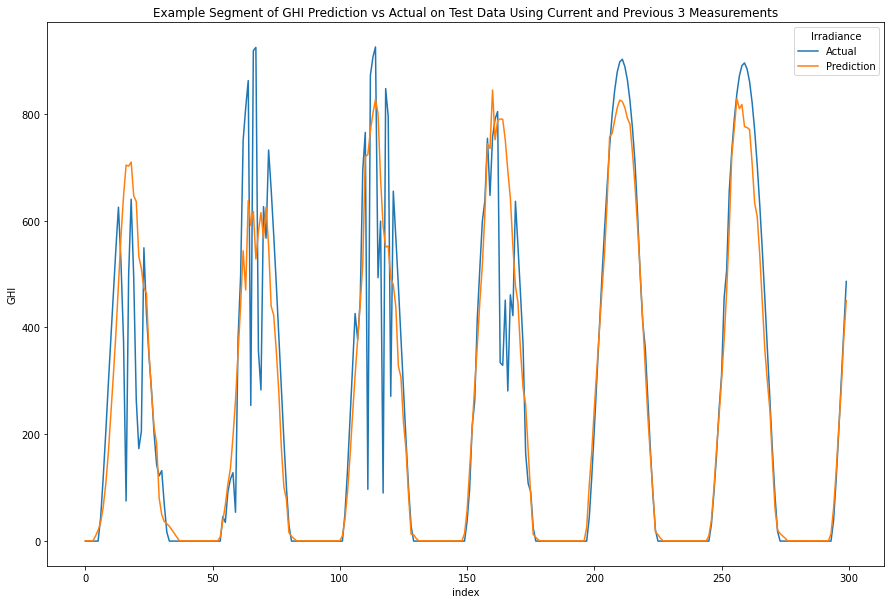

In [26]:
plot_df = pd.DataFrame({'Actual' : actual[100:400,0], 'Prediction' : prediction[100:400,0]})
plot_df = plot_df.reset_index().melt('index', var_name='Irradiance', value_name='GHI')

fig = plt.figure(figsize=(15,10))
sns.lineplot(data=plot_df, x='index', y='GHI', hue='Irradiance')
plt.title('Example Segment of GHI Prediction vs Actual on Test Data Using Current and Previous 3 Measurements')
plt.show()